# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

*Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?*

This overall modeling problem could be posed as either a classification or regression problem.

On the surface, whether a student needs early intervention or not seems like a classification problem: either a student is going to fail and need helped, or they do not need help. Given a student, we want to make a prediction between two possible outcomes. If the data and processes are available to support this, then working within a classification framework is probably the best place to start.

However, most educational organizations are not keeping data on who successfully received, or should have received, early intervention. It is more common to have data sets that involve grades, or a quantitative assessment. So a more straightforward and accessible approach may be to predict students outcomes with a regression model, and then intervene with the students whose predicted outcomes are within a certain range. 

There are two major advantages to a regression approach. First, it fits within the existing understanding of the problem---most educational organizations think in terms of grades. Second, it incorporates more meaningful data about a student's performance into the model by resolving different degrees of "pass" and "fail".

We will adress our specific problem as a classification problem, however, because

1. we *do* have the data and processes to enable this, and 
2. we want to predict the probability of a student passing or failing--the kind of problem that probabilistic classification is a natural fit for.

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import ensemble
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import f1_score
from sklearn import pipeline
from sklearn import grid_search

import matplotlib.pyplot as plt

In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print("Student data read successfully!")
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [3]:
student_data['passed'].head()

0     no
1     no
2    yes
3    yes
4    yes
Name: passed, dtype: object

In [4]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = len(student_data)
n_features = len(student_data.columns)-1
n_passed = len(student_data[student_data['passed']=='yes'])
n_failed = len(student_data[student_data['passed']=='no'])
grad_rate = float(n_passed)/float(n_passed+n_failed)*100.0 # as a percentage
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [5]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col] == "yes"  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows
print y_all.head()

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [6]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


In [7]:
X_all.head()

,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,1,0,1,0,18,0,1,1,0,1,...,1,0,0,4,3,4,1,1,3,6
1,1,0,1,0,17,0,1,1,0,0,...,1,1,0,5,3,3,1,1,3,4
2,1,0,1,0,15,0,1,0,1,0,...,1,1,0,4,3,2,2,3,3,10
3,1,0,1,0,15,0,1,1,0,0,...,1,1,1,3,2,2,1,1,5,2
4,1,0,1,0,16,0,1,1,0,0,...,1,0,0,4,3,2,1,2,5,4


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [8]:
# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset

In [9]:
n_train = 300
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, train_size=n_train, stratify=y_all)

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


In [10]:
print(X_train.head())
print(y_train.head())

     school_GP  school_MS  sex_F  sex_M  age  address_R  address_U  \
107          1          0      0      1   16          0          1   
228          1          0      0      1   18          0          1   
318          1          0      1      0   17          1          0   
134          1          0      0      1   15          1          0   
12           1          0      0      1   15          0          1   

     famsize_GT3  famsize_LE3  Pstatus_A    ...     higher  internet  \
107            1            0          0    ...          1         1   
228            0            1          0    ...          1         1   
318            1            0          0    ...          1         1   
134            1            0          0    ...          1         0   
12             0            1          0    ...          1         1   

     romantic  famrel  freetime  goout  Dalc  Walc  health  absences  
107         0       5         3      3     1     1       5         2  
228 

## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [11]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

# TODO: Choose a model, import it and instantiate an object
clf = ensemble.RandomForestClassifier(n_jobs=1, max_depth=15) # running on multiple cores actually makes this problem take longer

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
print(clf)  # you can inspect the learned model by printing it

Training RandomForestClassifier...
Done!
Training time (secs): 0.039
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [12]:
# Predict on training set and compute F1 score
def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred)

In [13]:
# Predict on train and test data
test_f1_score = predict_labels(clf, X_test, y_test)
train_f1_score = predict_labels(clf, X_train, y_train)

print "F1 score for test set: {}".format(test_f1_score)
print "F1 score for training set: {}".format(train_f1_score)

Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.005
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.003
F1 score for test set: 0.728682170543
F1 score for training set: 0.992555831266


In [14]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    
    train_classifier(clf, X_train, y_train)
    
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant

for train_size in [100, 200, 300]:
    train_predict(clf, X_train[:train_size], y_train[:train_size], X_test, y_test)


------------------------------------------
Training set size: 100
Training RandomForestClassifier...
Done!
Training time (secs): 0.037
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.001
F1 score for training set: 1.0
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.695652173913
------------------------------------------
Training set size: 200
Training RandomForestClassifier...
Done!
Training time (secs): 0.024
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.985815602837
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.760563380282
------------------------------------------
Training set size: 300
Training RandomForestClassifier...
Done!
Training time (secs): 0.038
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.003
F1 score for tra

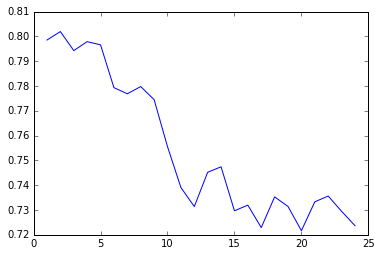

In [15]:
## find best max_depth for random forest
N_depth = np.arange(1, 25)
repeats = 5
f1_avg = np.zeros((N_depth.size, repeats))

for ii in range(len(N_depth)):
    nn = N_depth[ii]
    for jj in range(repeats):
        clf = ensemble.RandomForestClassifier(max_depth=nn)
        scores = cross_validation.cross_val_score(clf, X_all, y_all, scoring='f1', cv=4)
        f1_avg[ii, jj] = scores.mean()
        
plt.plot(N_depth, f1_avg.mean(axis=1))

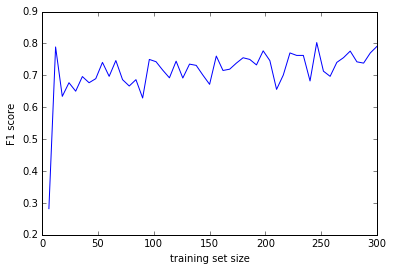

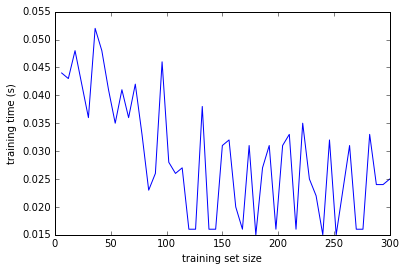

In [16]:
## find the minimum number of samples
def sample_sweep(clf, X_train, X_test, y_train, y_test, num_of_tests=10, spacing='linear'):
    n_samples_max = len(X_train)
    if spacing == 'linear':
        n_samples = np.linspace(0, n_samples_max, num_of_tests+1)
        n_samples = n_samples[1:]
    elif spacing == 'log':
        n_samples = np.logspace(0, np.log10(n_samples_max), num_of_tests)

    n_samples = n_samples.astype(int)
    
    f1 = np.zeros(num_of_tests)
    fit_pred_time = np.zeros(num_of_tests)
    
    for ii in range(len(n_samples)):
        nn = n_samples[ii]
        X_tmp = X_train.iloc[:nn, :]
        y_tmp = y_train.iloc[:nn]
        
        start_time = time.time()
        clf.fit(X_tmp, y_tmp)
        y_pred = clf.predict(X_test)
        fit_pred_time[ii] = time.time() - start_time
        
        f1[ii] = f1_score(y_test, y_pred)
        
    if spacing == 'linear':
        plt.plot(n_samples, f1)
    elif spacing == 'log':
        plt.semilogx(n_samples, f1)
    plt.xlabel("training set size")
    plt.ylabel("F1 score")
    
    plt.figure()
    if spacing == 'linear':
        plt.plot(n_samples, fit_pred_time)
    elif spacing == 'log':
        plt.semilogx(n_samples, fit_pred_time)
    plt.xlabel("training set size")
    plt.ylabel("training time (s)")

clf = ensemble.RandomForestClassifier(max_depth=15)

sample_sweep(clf, X_train, X_test, y_train, y_test, num_of_tests=50, spacing = 'linear')

In [17]:
# TODO: Train and predict using two other models

In [18]:
clf = linear_model.LogisticRegression(penalty='l2')
# X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, train_size=p_train)
# sample_sweep(clf, X_train, X_test, y_train, y_test, num_of_tests=50, spacing = 'linear')

for train_size in [100, 200, 300]:
    train_predict(clf, X_train[:train_size], y_train[:train_size], X_test, y_test)

------------------------------------------
Training set size: 100
Training LogisticRegression...
Done!
Training time (secs): 0.002
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.897959183673
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.717557251908
------------------------------------------
Training set size: 200
Training LogisticRegression...
Done!
Training time (secs): 0.004
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.870431893688
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.77519379845
------------------------------------------
Training set size: 300
Training LogisticRegression...
Done!
Training time (secs): 0.006
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.821345707

In [19]:
train_classifier(clf, X_train, y_train)

# Predict on train and test data
test_f1_score = predict_labels(clf, X_test, y_test)
train_f1_score = predict_labels(clf, X_train, y_train)

print "F1 score for test set: {}".format(test_f1_score)
print "F1 score for training set: {}".format(train_f1_score)

Training LogisticRegression...
Done!
Training time (secs): 0.005
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.003
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.005
F1 score for test set: 0.769230769231
F1 score for training set: 0.821345707657


In [20]:
clf = svm.SVC()
# X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, train_size=p_train)
# sample_sweep(clf, X_train, X_test, y_train, y_test, num_of_tests=50, spacing = 'linear')

for train_size in [100, 200, 300]:
    train_predict(clf, X_train[:train_size], y_train[:train_size], X_test, y_test)

------------------------------------------
Training set size: 100
Training SVC...
Done!
Training time (secs): 0.002
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.851851851852
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.810126582278
------------------------------------------
Training set size: 200
Training SVC...
Done!
Training time (secs): 0.006
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
F1 score for training set: 0.859756097561
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.810126582278
------------------------------------------
Training set size: 300
Training SVC...
Done!
Training time (secs): 0.011
Predicting labels using SVC...
Done!
Prediction time (secs): 0.008
F1 score for training set: 0.860215053763
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
F1 score for test set: 0.818181818182


In [21]:
train_classifier(clf, X_train, y_train)

# Predict on train and test data
test_f1_score = predict_labels(clf, X_test, y_test)
train_f1_score = predict_labels(clf, X_train, y_train)

print "F1 score for test set: {}".format(test_f1_score)
print "F1 score for training set: {}".format(train_f1_score)

Training SVC...
Done!
Training time (secs): 0.010
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
Predicting labels using SVC...
Done!
Prediction time (secs): 0.007
F1 score for test set: 0.818181818182
F1 score for training set: 0.860215053763


## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

I recommend using a support vector machine--it was the fastest, most accurate, and most memory efficient.

With the tests we ran, a support vector machine was both the most accurate at categorizing students and the fastest. In tests against other methods (random forest and logistic regression), it reliably categorized better than the others. Similary, when timing the classification step (including both the training step *and* the prediction step), it typically ran faster than the computer could accurately measure. Similarly, the memory usage was not measurable against the background processes of the computer.

In terms of the size of dataset required to make their best predictions, all the classifiers performed similarly, though the support vector machine was the most accurate with each amount of training data. At a training size of about 50 data points, the classifier has gained all the information it can. That said, if the dataset gets significanly larger and significanly more complex (for example, hundreds of thousands of students in a MOOC), then a support vector machine does not scale as well as other methods, and it may become resource intensive. As long as the size of the training set does not exceed about 10k (as a very conservative estimate), the literature suggests that it should work well.

Basically, an SVM works by finding the curves that divide the data up most effectively. It tries to keep the boundary right in between the two groups, and it tries to keep the two groups from mixing. The curves can be all sorts of shapes--ranging from simple lines to complicated curves. We'll pick our curve basically by trying them all and seeing which works best. Once we have our curves, whenever we see a new piece of data (or student, in this case) we just check which side of the curve she's on and we're done.

In [22]:
# TODO: Fine-tune your model and report the best F1 score
n_features = X_train.shape[1]

kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = 1.0 / n_features
gamma_list = np.logspace(0.005*gamma, 200.0*gamma, 17)

steps = [('svm', svm.SVC())]
pipe = pipeline.Pipeline(steps)
parameters = dict(svm__kernel = kernel_list,
                  svm__gamma = gamma_list)


clf = grid_search.GridSearchCV(pipe,
                               parameters, 
                               scoring='f1',
                               n_jobs=-1,
                               verbose=False,
                               cv=4)


In [23]:
train_predict(clf, X_train, y_train, X_test, y_test)

------------------------------------------
Training set size: 300
Training GridSearchCV...
Done!
Training time (secs): 6.831
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.010
F1 score for training set: 1.0
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.003
F1 score for test set: 0.805031446541


In [24]:
start_time = time.time()

clf.fit(X_train, y_train)

elapsed = time.time() - start_time

print("grid search time: " + str(elapsed))

grid search time: 6.85600018501


In [25]:
f1_train = f1_score(y_train, clf.predict(X_train))
f1_test = f1_score(y_test, clf.predict(X_test))

print("training set F1 score: " + str(f1_train))
print("test set F1 score: " + str(f1_test))

training set F1 score: 1.0
test set F1 score: 0.805031446541


In [26]:
clf.best_params_

{'svm__gamma': 1.0002398813807916, 'svm__kernel': 'rbf'}

The final, tested and tuned model is a support vector machine classifier with

* radial basis function kernel
* $\gamma = 1.0$.

Running the test a few time on different train-test splits, we get **$F_1 \approx 0.8$**.